# Data generation
* Generates data for a desired date based on the available APC data and passed through the model for load prediction.
* Will provide a distribution of bins which can be used for stochasticity
## Generates the following files:
* `trip_plan.json`
* `vehicle_plan.json`
* `sampled_loads.pkl`
* `chains.pkl`

In [1]:
from tensorflow.keras import backend as K
K.clear_session()
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import sys
import datetime as dt
import importlib
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql import functions as F
from pyspark import SparkConf
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Model
import IPython
from copy import deepcopy
from tqdm import trange, tqdm

mpl.rcParams['figure.facecolor'] = 'white'

import warnings

import pandas as pd
import swifter
pd.set_option('display.max_columns', None)
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.get_logger().setLevel('INFO')
import pyspark
print(pyspark.__version__)
spark = SparkSession.builder.config('spark.executor.cores', '8').config('spark.executor.memory', '80g')\
        .config("spark.sql.session.timeZone", "UTC").config('spark.driver.memory', '40g').master("local[26]")\
        .appName("wego-daily").config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC').config('spark.executor.extraJavaOptions', '-Duser.timezone=UTC')\
        .config("spark.sql.datetime.java8API.enabled", "true").config("spark.sql.execution.arrow.pyspark.enabled", "true")\
        .config("spark.sql.autoBroadcastJoinThreshold", -1)\
        .config("spark.driver.maxResultSize", 0)\
        .config("spark.shuffle.spill", "true")\
        .getOrCreate()

3.3.0
22/12/09 05:45:59 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/12/09 05:45:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 05:45:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
def get_apc_data_for_date(filter_date):
    print("Running this...")
    filepath = '/home/jptalusan/mta_stationing_problem/data/processed/apc_weather_gtfs_20220921.parquet'
    apcdata = spark.read.load(filepath)
    apcdata.createOrReplaceTempView("apc")

    plot_date = filter_date.strftime('%Y-%m-%d')
    get_columns = ['trip_id', 'transit_date', 'arrival_time', 'scheduled_time',
                'block_abbr', 'stop_sequence', 'stop_id_original',
                'vehicle_id', 'vehicle_capacity',
                'load', 
                'darksky_temperature', 
                'darksky_humidity', 
                'darksky_precipitation_probability', 
                'route_direction_name', 'route_id', 'overload_id',
                'dayofweek',  'year', 'month', 'hour', 'zero_load_at_trip_end',
                'sched_hdwy']
    get_str = ", ".join([c for c in get_columns])
    query = f"""
    SELECT {get_str}
    FROM apc
    WHERE (transit_date == '{plot_date}')
    ORDER BY arrival_time
    """
    apcdata = spark.sql(query)
    apcdata = apcdata.withColumn("route_id_dir", F.concat_ws("_", apcdata.route_id, apcdata.route_direction_name))
    apcdata = apcdata.withColumn("day", F.dayofmonth(apcdata.arrival_time))
    apcdata = apcdata.drop("route_direction_name")
    apcdata = apcdata.withColumn("load", F.when(apcdata.load < 0, 0).otherwise(apcdata.load))
    apcdata = apcdata.na.fill(value=0,subset=["zero_load_at_trip_end"])
    return apcdata

In [7]:
def prepare_input_data(input_df, ohe_encoder, label_encoders, num_scaler, columns, keep_columns=[], target='y_class'):
    num_columns = ['darksky_temperature', 'darksky_humidity', 'darksky_precipitation_probability', 'sched_hdwy']
    cat_columns = ['month', 'hour', 'day', 'stop_sequence', 'stop_id_original', 'year', 'time_window']
    ohe_columns = ['dayofweek', 'route_id_dir', 'is_holiday', 'is_school_break', 'zero_load_at_trip_end']

    # OHE
    input_df[ohe_encoder.get_feature_names_out()] = ohe_encoder.transform(input_df[ohe_columns]).toarray()
    # input_df = input_df.drop(columns=ohe_columns)

    # Label encoder
    for cat in cat_columns:
        print(cat)
        encoder = label_encoders[cat]
        input_df[cat] = encoder.transform(input_df[cat])
    
    # Num scaler
    input_df[num_columns] = num_scaler.transform(input_df[num_columns])
    input_df['y_class']  = input_df.y_class.astype('int')

    if keep_columns:
        columns = keep_columns + columns
    # Rearrange columns
    input_df = input_df[columns]
    
    return input_df

def assign_data_to_bins(df, TARGET='load'):
    bins = pd.IntervalIndex.from_tuples([(-1, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)])
    mycut = pd.cut(df[TARGET].tolist(), bins=bins)
    df['y_class'] = mycut.codes
    return df

In [8]:
TIMEWINDOW = 15
def add_features(df):
    df = df[df.arrival_time.notna()]
    df = df.fillna(method="bfill")

    df['day'] = df["arrival_time"].dt.day
    df = df.sort_values(by=['block_abbr', 'arrival_time']).reset_index(drop=True)

    # Adding extra features
    # Holidays
    fp = os.path.join('data', 'US Holiday Dates (2004-2021).csv')
    holidays_df = pd.read_csv(fp)
    holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
    holidays_df['is_holiday'] = True
    df = df.merge(holidays_df[['Date', 'is_holiday']], left_on='transit_date', right_on='Date', how='left')
    df['is_holiday'] = df['is_holiday'].fillna(False)
    df = df.drop(columns=['Date'])
        
    # School breaks
    fp = os.path.join('data', 'School Breaks (2019-2022).pkl')
    school_break_df = pd.read_pickle(fp)
    school_break_df['is_school_break'] = True
    df = df.merge(school_break_df[['Date', 'is_school_break']], left_on='transit_date', right_on='Date', how='left')
    df['is_school_break'] = df['is_school_break'].fillna(False)
    df = df.drop(columns=['Date'])

    df['minute'] = df['arrival_time'].dt.minute
    df['minuteByWindow'] = df['minute'] // TIMEWINDOW
    df['temp'] = df['minuteByWindow'] + (df['hour'] * 60 / TIMEWINDOW)
    df['time_window'] = np.floor(df['temp']).astype('int')
    df = df.drop(columns=['minute', 'minuteByWindow', 'temp'])

    # HACK
    # df = df[df['hour'] != 3]
    # df = df[df['stop_sequence'] != 0]

    df = df.sort_values(by=['block_abbr', 'arrival_time']).reset_index(drop=True)

    df = assign_data_to_bins(df, TARGET='load')
    return df

In [9]:
def setup_simple_lstm_generator(num_features, num_classes, learning_rate=1e-4):
    # define model
    model = tf.keras.Sequential()
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # compile model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["sparse_categorical_accuracy"],
    )

    input_shape = (None, None, num_features)
    model.build(input_shape)
    return model

def generate_simple_lstm_predictions(input_df, model, past, future):
    past_df = input_df[0:past]
    future_df = input_df[past:]
    predictions = []
    pred_probs = []
    if future == None:
        future = len(future_df)
    for f in range(future):
        pred = model.predict(past_df.to_numpy().reshape(1, *past_df.shape))
        pred_probs.append(pred)
        y_pred = np.argmax(pred)
        predictions.append(y_pred)
        
        # Add information from future
        last_row = future_df.iloc[[0]]
        last_row['y_class'] = y_pred
        past_df = pd.concat([past_df[1:], last_row])
        
        # Move future to remove used row
        future_df = future_df[1:]
    return predictions, pred_probs

In [10]:
def merge_overload_regular_bus_trips(regular, overload):
    m = regular.merge(overload, how='left', on=['trip_id', 'transit_date', 'scheduled_time', 'block_abbr', 'stop_sequence', 'stop_id_original', 'route_id_dir', 'route_id'])
    
    m['arrival_time'] = np.max(m[['arrival_time_x', 'arrival_time_y']], axis=1)
    
    m['zero_load_at_trip_end'] = m['zero_load_at_trip_end_x']
    
    m.loc[~m['arrival_time_x'].isnull(), "load"] = m['load_x']
    # m.loc[~m['arrival_time_x'].isnull(), "ons"] = m['ons_x']
    # m.loc[~m['arrival_time_x'].isnull(), "offs"] = m['offs_x']
    
    m.loc[~m['arrival_time_y'].isnull(), "load"] = m['load_y']
    # m.loc[~m['arrival_time_y'].isnull(), "ons"] = m['ons_y']
    # m.loc[~m['arrival_time_y'].isnull(), "offs"] = m['offs_y']
    
    m['vehicle_id'] = m['vehicle_id_x']
    m['vehicle_capacity'] = m['vehicle_capacity_x']
    m['overload_id'] = m['overload_id_x']
    m = m[m.columns.drop(list(m.filter(regex='_x')))]
    m = m[m.columns.drop(list(m.filter(regex='_y')))]
    # m = m[regular.columns]
    return m

In [11]:
# Load model
latest = tf.train.latest_checkpoint('models/no_speed')
columns = joblib.load('models/LL_X_columns.joblib')
label_encoders = joblib.load('models/LL_Label_encoders.joblib')
ohe_encoder = joblib.load('models/LL_OHE_encoder.joblib')
num_scaler = joblib.load('models/LL_Num_scaler.joblib')

In [12]:
DATE = '2021-03-05'
start_time = '08:00:00'
end_time = '12:00:00'

In [13]:
# 2021-10-18, 2021-11-23, 2021-12-15, 2022-01-
date_to_predict = dt.datetime.strptime(DATE, '%Y-%m-%d')
apcdata = get_apc_data_for_date(date_to_predict)
df = apcdata.toPandas()

# HACK
# a = df.query("trip_id == '233300' and vehicle_id == '722'").sort_values('stop_sequence')
# b = df.query("trip_id == '233300' and vehicle_id == '1830'").sort_values('stop_sequence')
# m1 = merge_overload_regular_bus_trips(a, b)

# a = df.query("trip_id == '259635' and vehicle_id == '2019'").sort_values('stop_sequence')
# b = df.query("trip_id == '259635' and vehicle_id == '1914'").sort_values('stop_sequence')
# m2 = merge_overload_regular_bus_trips(a, b)

df = df.query("overload_id == 0")
# overload_trips = df.query("overload_id > 0").trip_id.unique()
# df = df[~df['trip_id'].isin(overload_trips)]
# df = pd.concat([tdf, m1])
df = df.dropna(subset=['arrival_time'])
# df = df.fillna(method='ffill').fillna(method='bfill')

# HACK
# df = df.query("route_id != 95")
# df = df[~df['stop_id_original'].isin(['PEARL', 'JOHASHEN', 'ROS10AEN'])]

df = add_features(df)
raw_df = deepcopy(df)

# HACK
# df.loc[df['time_window'].isin([6, 7, 8]), 'time_window'] = 16

Running this...


22/12/01 02:41:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [36]:
input_df = prepare_input_data(df, ohe_encoder, label_encoders, num_scaler, columns, target='y_class')
ohe_columns = ['dayofweek', 'route_id_dir', 'is_holiday', 'is_school_break', 'zero_load_at_trip_end']
input_df = input_df.drop(columns=ohe_columns)

month
hour
day
stop_sequence
stop_id_original
year
time_window


In [37]:
import random
tf.keras.backend.clear_session()
percentiles = [(0, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)]

NUM_CLASSES = 5
FUTURE = None
PAST = 5

NUM_TRIPS = None
if NUM_TRIPS == None:
    rand_trips = df.trip_id.unique().tolist()
else:
    rand_trips = random.sample(df.trip_id.unique().tolist(), NUM_TRIPS)

model = setup_simple_lstm_generator(input_df.shape[1], NUM_CLASSES)
model.load_weights(latest)

trip_res = []
load_arr = []
for trip_id in tqdm(rand_trips):
    _df = df.query("trip_id == @trip_id")
    try:
        _input_df = input_df.loc[_df.index]
        _y_pred, y_pred_probs = generate_simple_lstm_predictions(_input_df, model, PAST, FUTURE)
        
        # Introducing stochasticity
        y_pred = [np.random.choice(len(ypp.flatten()), size=1, p=ypp.flatten())[0] for ypp in y_pred_probs]
        loads = [random.randint(percentiles[yp][0], percentiles[yp][1]) for yp in y_pred]
        
        _raw_df = raw_df.loc[_df.index]
        y_true = _raw_df[0:PAST]['load'].tolist()
        a = y_true + loads
        _raw_df['sampled_loads'] = a
        
        y_true_classes = _raw_df[0:PAST]['y_class'].tolist()
        _raw_df['y_pred_classes'] = y_true_classes + y_pred
        _raw_df['y_pred_probs'] = [[-1] * NUM_CLASSES]*len(y_true_classes) + [ypp[0] for ypp in y_pred_probs]
        
        trip_res.append(_raw_df)
    except:
        print(f"FAILED:{trip_id}")
        continue

trip_res = pd.concat(trip_res)

2022-11-30 20:05:23.424372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 20:05:23.878143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11402 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:0b:00.0, compute capability: 6.1
100%|██████████| 1005/1005 [14:42<00:00,  1.14it/s]


In [38]:
_columns = ['trip_id', 'transit_date', 'arrival_time', 'scheduled_time', 'block_abbr', 
            'stop_sequence', 'stop_id_original', 'route_id_dir', 'zero_load_at_trip_end', 
            'y_pred_classes', 'y_pred_probs', 'sampled_loads', 'vehicle_id', 'vehicle_capacity']
_trip_res = trip_res[_columns]

# fp = 'results/sampled_loads.pkl'
fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
_trip_res.to_pickle(fp)

### Matching with GTFS time points

In [14]:
# # fp = 'results/sampled_loads.pkl'
# # trip_res_df = pd.read_pickle(fp)
# # trip_res_df['trip_id'] = trip_res_df['trip_id'].astype('int')
# trip_res_df = _trip_res

# trip_res_df = pd.merge(trip_res_df, raw_df[['trip_id', 'scheduled_time', 'arrival_time', 'stop_id_original']], 
#                        left_on=['trip_id', 'scheduled_time', 'arrival_time', 'stop_id_original'], 
#                        right_on=['trip_id', 'scheduled_time', 'arrival_time', 'stop_id_original'], how='left')
# trip_res_df['trip_id'] = trip_res_df['trip_id'].astype('int')

# # print(trip_res_df.shape)
# stop_times_fp = 'data/GTFS/OCT2021/stop_times.txt'
# stop_times_df = pd.read_csv(stop_times_fp)
# # stop_times_df.query("trip_id == 264733")

# trip_res_df = pd.merge(trip_res_df, stop_times_df[['trip_id', 'stop_id', 'timepoint']], left_on=['trip_id', 'stop_id_original'], right_on=['trip_id', 'stop_id'])
# trip_res_df.query("trip_id == 264733")
# trip_res_df = trip_res_df.drop_duplicates(subset=['trip_id', 'stop_id_original', 'arrival_time', 'scheduled_time'])

# trip_res_arr = []
# for trip_id, trip_df in trip_res_df.groupby('trip_id'):
#     trip_df.loc[trip_df.index[-1], 'timepoint']= 1.0
#     trip_res_arr.append(trip_df)
    
# trip_res_df = pd.concat(trip_res_arr)

# # fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
# # trip_res_df.to_pickle(fp)
# trip_res_df

ValueError: No objects to concatenate

## Generate vehicle assignments here...
* Trying to limit to a window

In [2]:
{
    '2021-10-18':['121', '124', '140', '1824', '1830', '1900', '1920', '2013', '2015', '715', '720'],
    '2021-11-23':['1812', '1817', '1820', '1825', '1827', '1900', '1906', '1907', '2006', '2009'],
    '2021-12-15':['121', '134', '1800', '1804', '1812', '1821', '1826', '1830', '1904', '1908'],
    '2022-01-27':['129', '137', '1811', '1815', '1819', '1824', '1906', '1920', '2003', '2004'],
    '2022-02-25':['127', '130', '139', '141', '1814', '1820', '1823', '1901', '1913', '1916']
}

{'2021-10-18': ['121',
  '124',
  '140',
  '1824',
  '1830',
  '1900',
  '1920',
  '2013',
  '2015',
  '715',
  '720'],
 '2021-11-23': ['1812',
  '1817',
  '1820',
  '1825',
  '1827',
  '1900',
  '1906',
  '1907',
  '2006',
  '2009'],
 '2021-12-15': ['121',
  '134',
  '1800',
  '1804',
  '1812',
  '1821',
  '1826',
  '1830',
  '1904',
  '1908'],
 '2022-01-27': ['129',
  '137',
  '1811',
  '1815',
  '1819',
  '1824',
  '1906',
  '1920',
  '2003',
  '2004'],
 '2022-02-25': ['127',
  '130',
  '139',
  '141',
  '1814',
  '1820',
  '1823',
  '1901',
  '1913',
  '1916']}

In [7]:
DATE = '2021-12-15'
vehicle_list = ['121', '134', '1800', '1804', '1812', '1821', '1826', '1830', '1904', '1908', '2007']
start_time = '08:00:00'
end_time = '12:00:00'

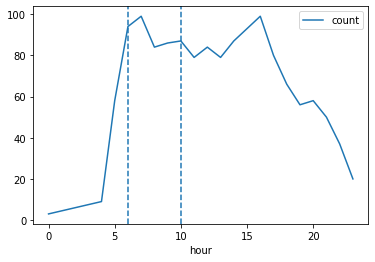

In [8]:
fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
trip_res_df = pd.read_pickle(fp)
trip_res_df['hour'] = trip_res_df.scheduled_time.dt.hour
trip_res_df['count'] = 1
ax = trip_res_df.groupby('trip_id').agg({"hour":"first", "count":"count"}).groupby("hour").count().plot(kind='line')
ax.axvline(x=6, ymin=0, ymax=100, ls='--')
ax.axvline(x=10, ymin=0, ymax=100, ls='--')

In [9]:
import json
# Vehicle assignments
# Each vehicle config is a dict: {vehicle_capacity, blocks}
DEFAULT_CAPACITY = 40.0
overall_vehicle_plan = {}

fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
trip_res_df = pd.read_pickle(fp)
trip_res_df = trip_res_df[trip_res_df['vehicle_id'].isin(vehicle_list)]
print(trip_res_df.trip_id.unique().shape)
print(trip_res_df.vehicle_id.unique().shape)

start_datetime = dt.datetime.strptime(f"{DATE} {start_time}", "%Y-%m-%d %H:%M:%S")
end_datetime = dt.datetime.strptime(f"{DATE} {end_time}", "%Y-%m-%d %H:%M:%S")

arr = []
for trip_id, trip_df in trip_res_df.groupby('trip_id'):
    if (trip_df.scheduled_time.min() >= start_datetime) and (trip_df.scheduled_time.max() <= end_datetime):
        arr.append(trip_df)

trip_res_df = pd.concat(arr)
print(trip_res_df.trip_id.unique().shape)
print(trip_res_df.vehicle_id.unique().shape)
trip_res_df

(219,)
(11,)
(45,)
(10,)


,trip_id,transit_date,arrival_time,scheduled_time,block_abbr,stop_sequence,stop_id_original,route_id_dir,zero_load_at_trip_end,y_pred_classes,y_pred_probs,sampled_loads,vehicle_id,vehicle_capacity,stop_id,timepoint
10809,259285,2021-12-15,2021-12-15 08:07:16,2021-12-15 08:15:00,1400,1,MCC4_20,14_FROM DOWNTOWN,0,1,"[-1, -1, -1, -1, -1]",8.0,1821,40.0,MCC4_20,1
10810,259285,2021-12-15,2021-12-15 08:19:12,2021-12-15 08:16:19,1400,2,UNI2AEF,14_FROM DOWNTOWN,0,1,"[-1, -1, -1, -1, -1]",8.0,1821,40.0,UNI2AEF,0
10811,259285,2021-12-15,2021-12-15 08:20:38,2021-12-15 08:17:52,1400,3,1SWOONM,14_FROM DOWNTOWN,0,1,"[-1, -1, -1, -1, -1]",8.0,1821,40.0,1SWOONM,0
10812,259285,2021-12-15,2021-12-15 08:20:58,2021-12-15 08:18:41,1400,4,1SJAMNM,14_FROM DOWNTOWN,0,1,"[-1, -1, -1, -1, -1]",8.0,1821,40.0,1SJAMNM,0
10813,259285,2021-12-15,2021-12-15 08:21:16,2021-12-15 08:19:24,1400,5,N1SOLDNM,14_FROM DOWNTOWN,0,0,"[-1, -1, -1, -1, -1]",6.0,1821,40.0,N1SOLDNM,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6150,264060,2021-12-15,2021-12-15 10:38:32,2021-12-15 10:34:53,600,60,ANDDESSN,6_FROM DOWNTOWN,0,0,"[0.5961582, 0.32973012, 0.07393855, 0.00017165...",4.0,1904,40.0,ANDDESSN,0
6151,264060,2021-12-15,2021-12-15 10:39:04,2021-12-15 10:35:56,600,61,ANDHIGSN,6_FROM DOWNTOWN,0,0,"[0.9862316, 0.0101123005, 0.0036561803, 6.3828...",3.0,1904,40.0,ANDHIGSN,0
6152,264060,2021-12-15,2021-12-15 10:39:50,2021-12-15 10:36:52,600,62,ANDRVISF,6_FROM DOWNTOWN,0,0,"[0.9708015, 0.021678776, 0.007519682, 7.727087...",6.0,1904,40.0,ANDRVISF,0
6153,264060,2021-12-15,2021-12-15 10:40:28,2021-12-15 10:38:27,600,63,ANDTYLSN,6_FROM DOWNTOWN,0,0,"[0.9622068, 0.02951225, 0.008280826, 7.070647e...",5.0,1904,40.0,ANDTYLSN,0


In [10]:

# TODO: run again with vehicle_capacity (above)
for vehicle_id, vehicle_df in trip_res_df.groupby('vehicle_id'):
    vehicle_df = vehicle_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    vehicle_capacity = vehicle_df.iloc[0].vehicle_capacity
    # vehicle_capacity = DEFAULT_CAPACITY
    if np.isnan(vehicle_capacity):
        vehicle_capacity = DEFAULT_CAPACITY
    # TODO: This is not the baseline behavior
    starting_depot = 'MCC5_1'
    service_type = 'regular'
    blocks = [block for block in vehicle_df.block_abbr.unique().tolist()]
    trips = []
    for block in blocks:
        block_df = vehicle_df.query("block_abbr == @block")
        for trip in block_df.trip_id.unique().tolist():
            trips.append((str(block), str(trip)))
    overall_vehicle_plan[vehicle_id] = {'vehicle_capacity': vehicle_capacity, 'trips': trips, 'starting_depot': starting_depot, 'service_type': service_type}
    
len(overall_vehicle_plan)

# Number of overload buses
#   "42": {
#     "service_type": "overload",
#     "starting_depot": "MCC5_1",
#     "trips": [
#     ],
#     "vehicle_capacity": 55.0
#   }
OVERLOAD_BUSES = 5
for vehicle_id in range(41, 41 + OVERLOAD_BUSES):
    overall_vehicle_plan[str(vehicle_id)] = {'vehicle_capacity': 55.0, 'trips': [], "starting_depot": "MCC5_1", 'service_type': "overload"}
    
with open(f'results/vehicle_plan_{DATE.replace("-", "")}_10_limited.json', 'w') as fp:
    json.dump(overall_vehicle_plan, fp, sort_keys=True, indent=2)

## Setting up Trip plan (sanity check)

In [9]:
# fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
# trip_res_df = pd.read_pickle(fp)

# Create a dict of {[block: {trip_ids:[]}, 'block'....]}
# trip_id dict = {'route_id', route_direction_name', 'stop_id':[], 'schedule_time':[]}
# Use block as grouper in baseline
overall_block_plan = {}
for block_abbr, block_df in trip_res_df.groupby('block_abbr'):
    block_df = block_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    trip_ids = block_df.trip_id.unique().tolist()
    start_time = block_df[block_df['trip_id'] == trip_ids[0]].iloc[0]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
    end_time = block_df[block_df['trip_id'] == trip_ids[-1]].iloc[-1]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
    overall_block_plan[block_abbr] = {'trip_ids': trip_ids,
                                      'start_time': start_time,
                                      'end_time': end_time}

overall_trip_plan = {}
for trip_id, trip_df in trip_res_df.groupby('trip_id'):
    trip_df = trip_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
    route_id_dir = trip_df.iloc[0].route_id_dir
    route_id = int(route_id_dir.split("_")[0])
    route_direction = route_id_dir.split("_")[1]
    zero_load_at_trip_end = trip_df.iloc[-1].zero_load_at_trip_end.tolist()
    scheduled_time = trip_df.scheduled_time.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
    stop_sequence = trip_df.stop_sequence.tolist()
    stop_sequence = list(range(0, len(stop_sequence)))
    # stop_sequence = [ss - 1 for ss in stop_sequence]
    stop_id_original = trip_df.stop_id_original.tolist()
    
    overall_trip_plan[trip_id] = {'route_id': route_id, 
                                  'route_direction': route_direction, 
                                  'scheduled_time': scheduled_time, 
                                  'stop_sequence': stop_sequence, 
                                  'stop_id_original': stop_id_original,
                                  'zero_load_at_trip_end':zero_load_at_trip_end,
                                  'last_stop_sequence': stop_sequence[-1],
                                  'last_stop_id': stop_id_original[-1]}

len(overall_trip_plan), len(overall_block_plan)

with open(f'results/trip_plan_{DATE.replace("-", "")}_10_limited.json', 'w') as fp:
    json.dump(overall_trip_plan, fp, sort_keys=True, indent=2)

In [ ]:
display(trip_res_df.query("trip_id == 259274").head())
print(trip_res_df.query("trip_id == 259274").shape)

In [ ]:
raw_df.query("trip_id == '243423'").shape

In [ ]:
# route_id_dir = 
# trip_res.query("route_id_dir == @route_id_dir and block_abbr == @block and stop_id_original == @stop_id_original[@i] and scheduled_time == @scheduled_time[@i]").iloc[0]['sampled_loads']

# Trip and Vehicle plan loop
* All buses and all day

In [8]:
import json
dates = ['2021-06-07', '2021-07-13', '2021-08-25', '2021-05-07']
# dates = ['2021-07-13']
TRUNCATE = True
vehicle_list = []


for date in dates:
    print(date)
    # Vehicle assignments
    # Each vehicle config is a dict: {vehicle_capacity, blocks}
    DEFAULT_CAPACITY = 10.0
    overall_vehicle_plan = {}

    fp = f'results/sampled_loads_{date.replace("-","")}.pkl'
    trip_res_df = pd.read_pickle(fp)
    

    if TRUNCATE:
        start_time = '08:00:00'
        end_time = '12:00:00'
        if vehicle_list:
            trip_res_df = trip_res_df[trip_res_df['vehicle_id'].isin(vehicle_list)]
            print(trip_res_df.trip_id.unique().shape)
            print(trip_res_df.vehicle_id.unique().shape)
            
        start_datetime = dt.datetime.strptime(f"{date} {start_time}", "%Y-%m-%d %H:%M:%S")
        end_datetime = dt.datetime.strptime(f"{date} {end_time}", "%Y-%m-%d %H:%M:%S")

        arr = []
        for trip_id, trip_df in trip_res_df.groupby('trip_id'):
            if (trip_df.scheduled_time.min() >= start_datetime) and (trip_df.scheduled_time.max() <= end_datetime):
                arr.append(trip_df)

        trip_res_df = pd.concat(arr)
        print(trip_res_df.trip_id.unique().shape)
        print(trip_res_df.vehicle_id.unique().shape)

    
    for vehicle_id, vehicle_df in trip_res_df.groupby('vehicle_id'):
        vehicle_df = vehicle_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
        vehicle_capacity = vehicle_df.iloc[0].vehicle_capacity
        vehicle_capacity = DEFAULT_CAPACITY
        # if np.isnan(vehicle_capacity):
        #     vehicle_capacity = DEFAULT_CAPACITY
        # TODO: This is not the baseline behavior
        starting_depot = 'MCC5_1'
        service_type = 'regular'
        blocks = [block for block in vehicle_df.block_abbr.unique().tolist()]
        trips = []
        for block in blocks:
            block_df = vehicle_df.query("block_abbr == @block")
            for trip in block_df.trip_id.unique().tolist():
                trips.append((str(block), str(trip)))
        overall_vehicle_plan[vehicle_id] = {'vehicle_capacity': vehicle_capacity, 'trips': trips, 'starting_depot': starting_depot, 'service_type': service_type}
        
    OVERLOAD_BUSES = 5
    for vehicle_id in range(41, 41 + OVERLOAD_BUSES):
        overall_vehicle_plan[str(vehicle_id)] = {'vehicle_capacity': 55.0, 'trips': [], "starting_depot": "MCC5_1", 'service_type': "overload"}
        
    if TRUNCATE:
        with open(f'results/vehicle_plan_{date.replace("-", "")}_limited.json', 'w') as fp:
            json.dump(overall_vehicle_plan, fp, sort_keys=True, indent=2)
    else:
        with open(f'results/vehicle_plan_{date.replace("-", "")}.json', 'w') as fp:
            json.dump(overall_vehicle_plan, fp, sort_keys=True, indent=2)
        
    overall_block_plan = {}
    for block_abbr, block_df in trip_res_df.groupby('block_abbr'):
        block_df = block_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
        trip_ids = block_df.trip_id.unique().tolist()
        start_time = block_df[block_df['trip_id'] == trip_ids[0]].iloc[0]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
        end_time = block_df[block_df['trip_id'] == trip_ids[-1]].iloc[-1]['scheduled_time'].strftime('%Y-%m-%d %H:%M:%S')
        overall_block_plan[block_abbr] = {'trip_ids': trip_ids,
                                        'start_time': start_time,
                                        'end_time': end_time}

    overall_trip_plan = {}
    for trip_id, trip_df in trip_res_df.groupby('trip_id'):
        trip_df = trip_df.dropna(subset=['arrival_time']).sort_values(['scheduled_time'])
        route_id_dir = trip_df.iloc[0].route_id_dir
        route_id = int(route_id_dir.split("_")[0])
        route_direction = route_id_dir.split("_")[1]
        zero_load_at_trip_end = trip_df.iloc[-1].zero_load_at_trip_end.tolist()
        scheduled_time = trip_df.scheduled_time.dt.strftime('%Y-%m-%d %H:%M:%S').tolist()
        stop_sequence = trip_df.stop_sequence.tolist()
        stop_sequence = list(range(0, len(stop_sequence)))
        # stop_sequence = [ss - 1 for ss in stop_sequence]
        stop_id_original = trip_df.stop_id_original.tolist()
        
        overall_trip_plan[trip_id] = {'route_id': route_id, 
                                    'route_direction': route_direction, 
                                    'scheduled_time': scheduled_time, 
                                    'stop_sequence': stop_sequence, 
                                    'stop_id_original': stop_id_original,
                                    'zero_load_at_trip_end':zero_load_at_trip_end,
                                    'last_stop_sequence': stop_sequence[-1],
                                    'last_stop_id': stop_id_original[-1]}

    len(overall_trip_plan), len(overall_block_plan)
        
    if TRUNCATE:
        with open(f'results/trip_plan_{date.replace("-", "")}_limited.json', 'w') as fp:
            json.dump(overall_trip_plan, fp, sort_keys=True, indent=2)
    else:
        with open(f'results/trip_plan_{date.replace("-", "")}.json', 'w') as fp:
            json.dump(overall_trip_plan, fp, sort_keys=True, indent=2)

2021-06-07
(302,)
(72,)
2021-07-13
(299,)
(70,)
2021-08-25
(285,)
(70,)
2021-05-07
(294,)
(66,)


## Getting ons and offs from sampled loads
* Needs the trip_res generated above
 ```
 fp = 'results/sampled_loads.pkl'
 trip_res.to_pickle(fp)
```

In [ ]:
import pandas as pd

def compute_ons_offs(s):
    curr_load = s['sampled_loads']
    next_load = s['next_load']
    if next_load > curr_load:
        ons = next_load - curr_load
        offs = 0
    elif next_load < curr_load:
        ons = 0
        offs = curr_load - next_load
    else:
        ons = 0
        offs = 0
        
    return ons, offs
    
# fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
# trip_res = pd.read_pickle(fp)
trip_res = _trip_res
sampled_ons_offs = []
for trip_id, trip_id_df in tqdm(trip_res.groupby(['transit_date', 'trip_id'])):
    tdf = trip_id_df.sort_values('stop_sequence').reset_index(drop=True)
    tdf['ons'] = 0
    tdf['offs'] = 0
    tdf['next_load'] = tdf['sampled_loads'].shift(-1)
    
    # Intermediate stops
    tdf[['ons', 'offs']] = tdf.apply(compute_ons_offs, axis=1, result_type="expand")
    
    # first and last stops
    tdf.at[0, 'ons'] = tdf.iloc[0]['sampled_loads']
    tdf.at[len(tdf) - 1, 'offs'] = tdf.iloc[-1]['sampled_loads']
    sampled_ons_offs.append(tdf)
    
sampled_ons_offs = pd.concat(sampled_ons_offs)
sampled_ons_offs = sampled_ons_offs.drop('next_load', axis=1)

# fp = f'results/sampled_ons_offs_{DATE.replace("-", "")}.pkl'
# sampled_ons_offs.to_pickle(fp)

## Generating a single event chain


In [ ]:
import random
import pandas as pd

def compute_ons_offs(s):
    curr_load = s['sampled_loads']
    next_load = s['next_load']
    if next_load > curr_load:
        ons = next_load - curr_load
        offs = 0
    elif next_load < curr_load:
        ons = 0
        offs = curr_load - next_load
    else:
        ons = 0
        offs = 0
        
    return ons, offs

percentiles = [(0, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)]

# fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
# trip_res = pd.read_pickle(fp)
trip_res = _trip_res
loads = [random.randint(percentiles[yp][0], percentiles[yp][1]) for yp in trip_res.y_pred_classes]
trip_res['sampled_loads'] = loads

sampled_ons_offs = []
for trip_id, trip_id_df in tqdm(trip_res.groupby(['transit_date', 'trip_id'])):
    tdf = trip_id_df.sort_values('stop_sequence').reset_index(drop=True)
    tdf['stop_sequence'] = list(range(1, len(tdf) + 1))
    tdf['ons'] = 0
    tdf['offs'] = 0
    tdf['next_load'] = tdf['sampled_loads'].shift(-1)
    
    # Intermediate stops
    tdf[['ons', 'offs']] = tdf.apply(compute_ons_offs, axis=1, result_type="expand")
    
    # first and last stops
    tdf.at[0, 'ons'] = tdf.iloc[0]['sampled_loads']
    tdf.at[len(tdf) - 1, 'offs'] = tdf.iloc[-1]['sampled_loads']
    sampled_ons_offs.append(tdf)
    
df = pd.concat(sampled_ons_offs)
df = df.drop('next_load', axis=1)

display(df)
df['key_pair'] = list(zip(df.route_id_dir, 
                          df.block_abbr,
                          df.stop_sequence,
                          df.stop_id_original, 
                          df.scheduled_time))
df = df.set_index('key_pair')
drop_cols = ['trip_id', 'route_id_dir', 'block_abbr', 'stop_id_original', 'stop_id', 'scheduled_time', 
                'transit_date', 'arrival_time', 'zero_load_at_trip_end', 'y_pred_classes', 'y_pred_probs',
                'vehicle_capacity', 'vehicle_id', 'stop_sequence']
drop_cols = [dc for dc in drop_cols if dc in df.columns]
df = df.drop(drop_cols, axis=1)
sampled_ons_offs_dict = df.to_dict('index')

import pickle 

# with open(f'results/sampled_ons_offs_dict_{DATE.replace("-", "")}.pkl', 'wb') as handle:
#     pickle.dump(sampled_ons_offs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# df[('23_FROM DOWNTOWN', 2310, 'DWMRT', pd.Timestamp('2021-08-23 05:41:00'))]
df.query("route_id_dir == '23_FROM DOWNTOWN' and block_abbr == 2310 and stop_id_original == 'DWMRT' and scheduled_time == '2021-08-23 05:41:00'")

In [ ]:
key = list(sampled_ons_offs_dict.keys())[0]
print(key)
sampled_ons_offs_dict[key]

In [ ]:
# df.query("route_id_dir == '7_TO DOWNTOWN' and block_abbr == 5692 and stop_sequence == 20 and stop_id_original == 'MCC5_9'")
# df.query("route_id_dir == '7_TO DOWNTOWN' and block_abbr == 5692")

## Generating multiple event chains

In [ ]:
import random
import pandas as pd
import pickle
from tqdm import tqdm

def compute_ons_offs(s):
    curr_load = s['sampled_loads']
    next_load = s['next_load']
    if next_load > curr_load:
        ons = next_load - curr_load
        offs = 0
    elif next_load < curr_load:
        ons = 0
        offs = curr_load - next_load
    else:
        ons = 0
        offs = 0
        
    return ons, offs

CHAINS = 5
percentiles = [(0, 6.0), (6.0, 12.0), (12.0, 55.0), (55.0, 75.0), (75.0, 100.0)]

# fp = f'results/sampled_loads_{DATE.replace("-","")}.pkl'
# trip_res = pd.read_pickle(fp)
trip_res = _trip_res
for chain in tqdm(range(CHAINS)):
    loads = [random.randint(percentiles[yp][0], percentiles[yp][1]) for yp in trip_res.y_pred_classes]
    trip_res['sampled_loads'] = loads

    sampled_ons_offs = []
    for trip_id, trip_id_df in trip_res.groupby(['transit_date', 'trip_id']):
        tdf = trip_id_df.sort_values('stop_sequence').reset_index(drop=True)
        tdf['stop_sequence'] = list(range(1, len(tdf) + 1))
        tdf['ons'] = 0
        tdf['offs'] = 0
        tdf['next_load'] = tdf['sampled_loads'].shift(-1)
        
        # Intermediate stops
        tdf[['ons', 'offs']] = tdf.apply(compute_ons_offs, axis=1, result_type="expand")
        
        # first and last stops
        tdf.at[0, 'ons'] = tdf.iloc[0]['sampled_loads']
        tdf.at[len(tdf) - 1, 'offs'] = tdf.iloc[-1]['sampled_loads']
        sampled_ons_offs.append(tdf)
        
    df = pd.concat(sampled_ons_offs)
    df['key_pair'] = list(zip(df.route_id_dir, 
                            df.block_abbr,
                            df.stop_sequence,
                            df.stop_id_original, 
                            df.scheduled_time))
    df = df.set_index('key_pair')
    drop_cols = ['trip_id', 'route_id_dir', 'block_abbr', 'stop_id_original', 'stop_id', 'scheduled_time', 
                 'transit_date', 'arrival_time', 'zero_load_at_trip_end', 'y_pred_classes', 'y_pred_probs',
                 'vehicle_capacity', 'vehicle_id', 'stop_sequence']
    drop_cols = [dc for dc in drop_cols if dc in df.columns]
    df = df.drop(drop_cols, axis=1)
    sampled_ons_offs_dict = df.to_dict('index')

    with open(f'results/chains/ons_offs_dict_chain_{DATE.replace("-","")}_{chain}.pkl', 'wb') as handle:
        pickle.dump(sampled_ons_offs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Create timepoint dict


In [ ]:
stop_times_df.iloc[0].arrival_time[2:]

In [15]:
def fix_time(x):
    if x[0:2] == '24':
        return '00'+x[2:]
    if x[0:2] == '25':
        return '01'+x[2:]
    return x
    
stop_times_fp = 'data/GTFS/OCT2021/stop_times.txt'
stop_times_df = pd.read_csv(stop_times_fp)
# stop_times_df.query("trip_id == 264733")
stop_times_df['date'] = DATE
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(lambda x: fix_time(x))
stop_times_df['scheduled_time'] = pd.to_datetime(stop_times_df['date'] + ' ' + stop_times_df['arrival_time'])

stop_times_df['key_pair'] = list(zip(stop_times_df.trip_id, stop_times_df.stop_id, stop_times_df.scheduled_time))
stop_times_df = stop_times_df.set_index('key_pair')

time_point_dict = stop_times_df.drop(['arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'stop_headsign', 'trip_id',
                                      'pickup_type', 'drop_off_type', 'shape_dist_traveled', 'scheduled_time', 'date'], axis=1).to_dict('index')
with open(f'results/time_point_dict_{DATE.replace("-", "")}.pkl', 'wb') as handle:
    pickle.dump(time_point_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# time_point_dict

In [ ]:
[(k, tp) for k, tp in time_point_dict.items() if k[0] == 263558][0]

In [ ]:
time_point_dict[(263558, 'GALBERNN', pd.Timestamp('2021-10-18 05:47:59'))]

# OUTPUT: 
* Copy these to `scenarios/baselines/data`
    * results/sampled_ons_offs_dict
    * results/chains/ons_offs_dict_chain_{chain}.pkl
    * results/trip_plan.json
    * results/vehicle_plan.json
    * results/time_point_dict.pkl

## Structure:
```
{key:val}
key: (tuple) (route_id_dir, block_abbr, stop_sequene, stop_id, scheduled_arrival_time)
val: (dict) {'sampled_loads': A, 'ons': B, 'offs': C}
```

In [ ]:
## Sanity check
CHAINS = 5
for chain in range(CHAINS):
    with open(f'results/chains/ons_offs_dict_chain_{chain}.pkl', 'rb') as handle:
        sampled_ons_offs_dict = pickle.load(handle)
    # res = sampled_ons_offs_dict[('7_TO DOWNTOWN', 5692, 20, 'MCC5_9', pd.Timestamp('2021-08-23 14:39:00'))]
    res = sampled_ons_offs_dict[('14_FROM DOWNTOWN', 1400, 1, 'MCC4_20', pd.Timestamp('2021-10-18 14:15:00'))]
    print(f"chain {chain}: {res}")

In [ ]:
list(sampled_ons_offs_dict.keys())[0], list(sampled_ons_offs_dict.values())[0]

In [ ]:
import datetime as dt
with open(f'results/chains/ons_offs_dict_chain_0.pkl', 'rb') as handle:
    sampled_ons_offs_dict = pickle.load(handle)
# ('7_TO DOWNTOWN', 5692, 1, 'HBHS', datetime.datetime(2021, 8, 23, 14, 9))
# sampled_ons_offs_dict[('7_TO DOWNTOWN', 5692, 1, 'HBHS', dt.datetime(2021, 8, 23, 14, 9))]
search_key = ('7_TO DOWNTOWN', 5692, 5)
values = [value for key, value in sampled_ons_offs_dict.items() if search_key == key[:len(search_key)]]
keys = [key for key, value in sampled_ons_offs_dict.items() if search_key == key[:len(search_key)]]
values, keys

In [ ]:
list(sampled_ons_offs_dict.keys())[0], list(sampled_ons_offs_dict.values())[0]

In [ ]:
import datetime as dt
sampled_ons_offs_dict[('14_FROM DOWNTOWN', 1400, 1, 'MCC4_20', dt.datetime(2021, 8, 23, 14, 15))]
('14_FROM DOWNTOWN', 1400, 1, 'MCC4_20', dt.datetime(2021, 8, 23, 14, 15))
('14_FROM DOWNTOWN', '1400', 1, 'MCC4_20', dt.datetime(2021, 8, 23, 14, 15))
# ('14_FROM DOWNTOWN', '1400', 1, 'MCC4_20', datetime.datetime(2021, 8, 23, 14, 15))

In [ ]:
# 263159
import pandas as pd

fp = 'results/sampled_ons_offs_dict_20211018.pkl'
df = pd.read_pickle(fp)
list(df.keys())[0]

In [ ]:
rid = '55_FROM DOWNTOWN'
sid = 'MCC4_15'
time = '2021-10-18 15:35:00'

df[('14_FROM DOWNTOWN', 1400, 1, 'MCC4_20', pd.Timestamp('2021-10-18 14:15:00'))]

In [ ]:
[(k, v)for k, v in df.items() if k[0] == rid and k[3] == sid and k[4] == pd.Timestamp(time)]

In [6]:
import pickle
fp = '/home/jptalusan/gits/mta_simulator_redo/data_generation/results/sampled_ons_offs_dict_20211018.pkl'

with open(fp, 'rb') as handle:
    sampled_ons_offs_dict = pickle.load(handle)

In [7]:
sampled_ons_offs_dict

{('14_FROM DOWNTOWN',
  1400,
  1,
  'MCC4_20',
  Timestamp('2021-10-18 08:15:00')): {'sampled_loads': 43, 'timepoint': 1, 'ons': 43.0, 'offs': 0.0, 'next_load': 45.0},
 ('14_FROM DOWNTOWN',
  1400,
  2,
  'UNI2AEF',
  Timestamp('2021-10-18 08:16:19')): {'sampled_loads': 45, 'timepoint': 0, 'ons': 0.0, 'offs': 27.0, 'next_load': 18.0},
 ('14_FROM DOWNTOWN',
  1400,
  3,
  '1SWOONM',
  Timestamp('2021-10-18 08:17:52')): {'sampled_loads': 18, 'timepoint': 0, 'ons': 11.0, 'offs': 0.0, 'next_load': 29.0},
 ('14_FROM DOWNTOWN',
  1400,
  4,
  '1SJAMNM',
  Timestamp('2021-10-18 08:18:41')): {'sampled_loads': 29, 'timepoint': 0, 'ons': 8.0, 'offs': 0.0, 'next_load': 37.0},
 ('14_FROM DOWNTOWN',
  1400,
  5,
  'N1SOLDNM',
  Timestamp('2021-10-18 08:19:24')): {'sampled_loads': 37, 'timepoint': 0, 'ons': 0.0, 'offs': 11.0, 'next_load': 26.0},
 ('14_FROM DOWNTOWN',
  1400,
  6,
  'DICGRANN',
  Timestamp('2021-10-18 08:21:21')): {'sampled_loads': 26, 'timepoint': 0, 'ons': 0.0, 'offs': 5.0, 'next_